In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing
# Import the ARIMA object
from statsmodels.tsa.arima.model import ARIMA

# Prediction of Time Series Data - Basic Methods

In this notebook, we use simple methods, like the naive method, simple exponential smoothing and ARIMA, to predict time series data and take a look at the RMSE of percentage errors.

First, read the time series data:

In [2]:
# Get time series data:
data = pd.read_csv('SteamCharts.csv',low_memory=False)

# Replace inf to NaN:
data = data.replace({np.inf:np.nan})
data = data.replace({'+Inf':np.nan})

The file ``SteamCharts.csv`` contains the peak number of players, average number of players, gain and percentage gain. The following codes allows you to extract all of them seperately. In this notebook, we focus on predicting the average number of players.

In [3]:
# Get Avg_Players.

# Get Perc_Gain.
p_gain = data.loc[data['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
p_gain_pure = p_gain.drop(columns=['App_id', 'Name']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_players = avg_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)

# Get Peak_Players.
peak_players = data.loc[data['Peak_Players']==1]
peak_players = peak_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
peak_pure = peak_players.drop(columns=['App_id', 'Name']).astype(float)

# Add columns of max and mean
avg_players['max'] = avg_pure.max(axis=1)
avg_players['mean'] = avg_pure.mean(axis=1)

peak_players['peak_max'] = peak_pure.max(axis=1)
peak_players['peak_mean'] = peak_pure.mean(axis=1)

Let us now select games with
- max of avg_players is larger than or equal to 10,
- release time between July 2012 and March 2021, and
- no 'NaN' in between the time series.

In [4]:
avg_pure = avg_pure.loc[avg_players['max']>0]
avg_pure = avg_pure.loc[avg_players['max'].isna()==False]
avg_pure = avg_pure.reset_index(drop=True)

avg_players = avg_players.loc[avg_players['max']>0]
avg_players = avg_players.loc[avg_players['max'].isna()==False]
avg_players = avg_players.reset_index(drop=True)

birth = [avg_pure.iloc[i].last_valid_index() for i in range(len(avg_pure))]
avg_players['birth']=birth

In [5]:
#Select games with max of avg_players >=10

avg1 = avg_players.loc[avg_players['max']>=10]
avg_pure1 = avg_pure.loc[avg_players['max']>=10]


#Select games with release time between July 2012 and March 2021

avg1 = avg1.loc[avg_players['birth']!='July 2012'].reset_index(drop=True)
avg_pure1 = avg_pure1.loc[avg_players['birth']!='July 2012'].reset_index(drop=True)

#Select games with no NaN data in between

incomplete_data = []
for i in range(len(avg1)):
    temp = avg_pure1.iloc[i]
    if np.isnan(temp[temp.first_valid_index():temp.last_valid_index()]).any():
        incomplete_data.append(i)
len(incomplete_data)

avg_players = avg1.drop(incomplete_data).reset_index(drop=True)
avg_pure = avg_pure1.drop(incomplete_data).reset_index(drop=True)

months = pd.to_datetime(avg_pure.iloc[0].index)

# Accuracy of Naive, SES and ARIMA

Next we compute the accuracy of prediction models on the same test set using basic methods, as a comparison to our prediction model. We will use m months data to predict next n months. For example, take m=12 and n=6.

The following function allows us to save time series data for each game as a seperate dataframe:

In [6]:
def nonsmooth_values(data):
    nonsmooth = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()].values
        nonsmooth.append(temp)
    return nonsmooth

Define the root mean square error for computing percentage error.

In [7]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2)/len(b))

def get_error(a,b):
    # percentage RMSE 
    return rootmse(a,b)/rootmse(0,b)

The following function returns the errors of 
- naive method, 
- SES, 
- the average of naive and SES

ARIMA will be applied seperately, as it is much slower.

In [8]:
#dropping datas with less than x months: x = cutoff

cutoff = 18

data = avg_players.copy()
data_pure = avg_pure.copy()
list1 = []
for i in range(len(data)):
    if len(data_pure.iloc[i][data_pure.iloc[i].first_valid_index():data_pure.iloc[i].last_valid_index()])<cutoff:
        list1.append(i)
data=data.drop(index = list1).reset_index(drop=True)
data_pure=data_pure.drop(index = list1).reset_index(drop=True)

print('There are in total ' + str(len(data)) + ' games with '+str(cutoff) +'-month data.')

There are in total 4289 games with 18-month data.


In [9]:
def simpl_model_error(data, time_total=cutoff ,time_for_pred=6):
    data_copy=data.copy()
    data = nonsmooth_values(data_copy)
    time_start=time_total-time_for_pred
    data_total = []
    for i in range(len(data)):
        data_total.append(data[i][:time_total])
    
    data_start = [data[i][:time_start] for i in range(len(data))]
    data_for_pred = [data[i][time_start:time_total] for i in range(len(data))]
    naive_error=[]
    exp_error=[]
    arima_error=[]
    new_error=[]
    
    for i in range(len(data)):
        test = data_for_pred[i]
        if rootmse(0,test)!=0:
            pred_naive = np.ones(time_for_pred) * (data_start[i][-1])
            error_naive = get_error(pred_naive,test)
            naive_error.append(error_naive)
        
            ses = SimpleExpSmoothing(data_start[i])
            fit = ses.fit(smoothing_level=.6, optimized=False)
            pred_exp = fit.forecast(time_for_pred)
            error_exp = get_error(pred_exp,test)
            exp_error.append(error_exp)
            
            pred_new = (pred_naive+pred_exp)/2
            error_new = get_error(pred_new,test)
            new_error.append(error_new)
            
    return naive_error, exp_error, new_error

In [10]:
errors = simpl_model_error(data_pure, time_for_pred=6)
errors_mean = [np.mean(errors[i]) for i in range(len(errors))]

print('The average percentage error is '+str(errors_mean))

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


The average percentage error is [0.509738395258373, 0.5017761447426813, 0.5015697324185324]


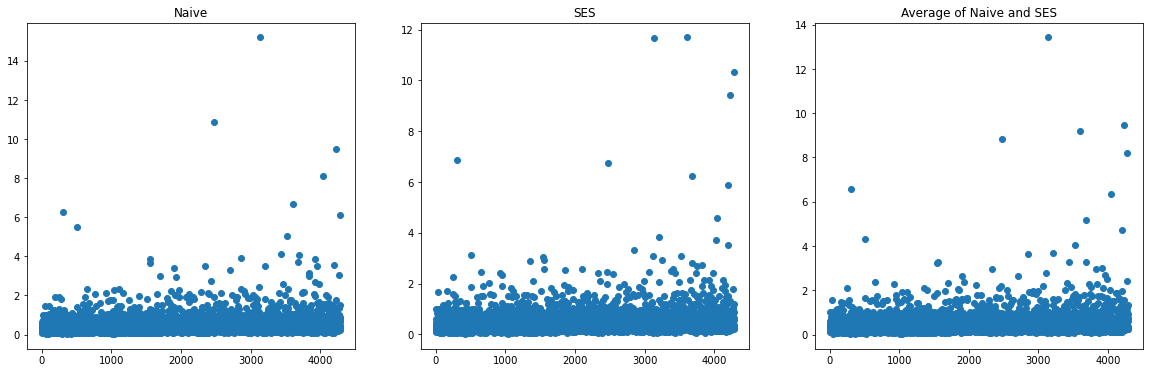

In [11]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
for i in range(3):
    ax[i].scatter(range(len(errors[i])),errors[i])
ax[0].set_title('Naive')
ax[1].set_title('SES')
ax[2].set_title('Average of Naive and SES')
plt.show()

We take a look at the performance of ARIMA:

In [12]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def arima_error(data, time_total=cutoff ,time_for_pred=6):
    data_copy=data.copy()
    data = nonsmooth_values(data_copy)
    time_start=time_total-time_for_pred
    data_total = []
    for i in range(len(data)):
        data_total.append(data[i][:time_total])
    
    data_start = [data[i][:time_start] for i in range(len(data))]
    data_for_pred = [data[i][time_start:time_total] for i in range(len(data))]
    arima_error=[]

    for i in range(len(data)):
        test = data_for_pred[i]
        if rootmse(0,test)!=0:
            norm = rootmse(0,test)
            arima = ARIMA(data_start[i], order = (1,1,2))
            arima_fit = arima.fit()
            pred_arima = arima_fit.forecast(time_for_pred)
            error_arima = rootmse(pred_arima,test)/norm
            arima_error.append(error_arima)
            
    return arima_error

In [13]:
errors_arima = arima_error(data_pure, time_for_pred=6)
errors_arima_mean = np.mean(errors)

print('The average percentage error of ARIMA is '+str(errors_arima_mean))

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The average percentage error of ARIMA is 0.5043614241398622


## Plotting

At the end of this notebook, we plot the prediction curve for visual comparasion.

In [14]:
plt.style.use('dark_background')

In [15]:
def pred_plot(data, i_game,pred_k=6, smoothing_level=.2,title='Prediction',save_fig=False):
    
    data_copy=data.copy()
    data1 = nonsmooth_values(data_copy)
    game=data1[i_game]
    time_start=cutoff-pred_k
    
    train = game[:time_start]
    test = game[time_start:cutoff]
    
    fig=plt.figure(figsize=(8,6))
    plt.plot(range(time_start),train,'m',label = "Training Data")
    plt.plot(range(time_start+1,cutoff+1),test,'m--',label = "Test Data")
    
    ses = SimpleExpSmoothing(train)
    ses_fit = ses.fit(smoothing_level=smoothing_level, optimized=False)
    plt.plot(range(time_start),ses_fit.fittedvalues,'y-',label = "SES Fitted Values")
    plt.plot(range(time_start+1,cutoff+1),ses_fit.forecast(len(test)),'y--',label = "SES Forecast")
    
    arima = ARIMA(train, order = (1,1,2))
    arima_fit = arima.fit()
    plt.plot(range(time_start),arima_fit.fittedvalues,'r-',label = "ARIMA Fitted Values")
    plt.plot(range(time_start+1,cutoff+1),arima_fit.forecast(len(test)),'r--',label = "ARIMA Forecast")
    
    plt.plot(range(time_start+1,cutoff+1),np.ones(len(test))*train[-1],'--',label = "Naive Forecast")
    
    plt.legend(fontsize=14)
    plt.ylabel(str(avg_players.Name.iloc[i_game]))
    plt.title('Simple Methods')
    plt.show()
    
    if save_fig:
        fig.savefig('ExamplePlot2.png',bbox_inches="tight")

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


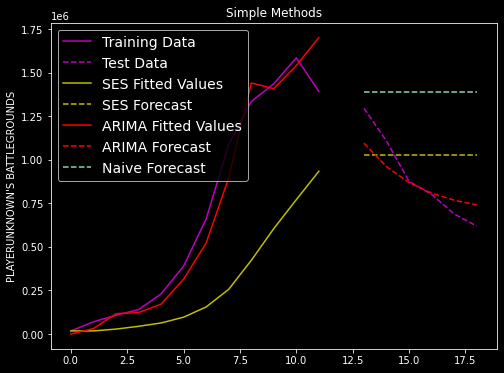

In [16]:
avg_plot = avg_players.drop(columns=['Name','App_id', 'max','mean','birth'])
pred_plot(avg_plot,0)